In [1]:
from brownpy.gpu_sim import Universe
import matplotlib.pyplot as plt
import h5py
import cupy as cp
import numpy as np
from tqdm.auto import tqdm
plt.style.use('dark_background')

In [2]:
dt = int(1E6) #fs (1ns) - time steps
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

# Geometry
L = 1E3 # A (100nm) - channel length
h = 1E2 # A (10nm)  - channel height
R = 1E4 # A (1um) - reservoir size

N= 16*1024

In [3]:
u = Universe(N=N, L=L, h=h, R=R, D=D, dt=dt,
             output_path='simu')

simu.hdf5 already exists, change output filename for simu_4.hdf5


In [4]:
u.run(1_000_000_000);

100%|██████████| 1000000000/1000000000 [1:24:36<00:00, 196996.85it/s, total=1  s]


With 16384 particles
------------------------------------------
GPU time per step:
Allocation: 1.19 ps
Engine: 504 ps
Transfert to RAM: 934 fs
Total: 506 ps
------------------------------------------
CPU time per step:
Other: 506 ps
Transfert to drive: 627 fs
Total: 506 ps


UnboundLocalError: local variable 'i_trajecry' referenced before assignment

In [4]:
u.run(1_000_000, freq_dumps=10);

100%|██████████| 1000000/1000000 [00:28<00:00, 35048.48it/s, total=1 ms]

With 8192 particles
------------------------------------------
GPU time per step:
Allocation: 473 ns
Engine: 285 ns
Transfert to RAM: 2.09 µs
Total: 2.85 µs
------------------------------------------
CPU time per step:
Other: 869 ns
Transfert to drive: 1.98 µs
Total: 2.85 µs


In [3]:
u = Universe.from_hdf5('simu_3.hdf5')

In [4]:
data = u[0]

Reading region_0 ...
... Done
Reading trajectory ...
... Done


In [5]:
trajectory = data['trajectory']

In [30]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
binx = np.concatenate((
        np.arange(-R-L/2,-L,100),
        np.arange(-L,-L/2,50),
        np.arange(-L/2,+L/2,20),
        np.arange(+L/2,+L,50),
        np.arange(+L,+R+L/2+1,100),
))

binz = np.concatenate((
        np.arange(-R,-L,100),
        np.arange(-L,-h/2,50),
        np.arange(-h/2,+h/2,20),
        np.arange(+h/2,+L,50),
        np.arange(+L,+R+1,100),
))

d_binx = cp.asarray(binx)
d_binz = cp.asarray(binz)
i=0

x = cp.asarray(trajectory[:,0,i::10].flatten())
z = cp.asarray(trajectory[:,1,i::10].flatten())
d_hist, ex, ez = cp.histogram2d(x, z, bins = (d_binx, d_binz), density=True)
for i in range(1, 10):
        x = cp.asarray(trajectory[:,0,i::10].flatten())
        z = cp.asarray(trajectory[:,1,i::10].flatten())
        d_hist2, d_ex, d_ez = cp.histogram2d(x, z, bins = (d_binx, d_binz), density=True)
        d_hist += d_hist2
hist=d_hist.get().T
ex, ez = d_ex.get(), d_ez.get()
del d_binx, d_binz
del x, z
del d_ex, d_ez
del d_hist, d_hist2
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [44]:
mean, std = np.mean(hist[hist>0]), np.std(hist[hist>0])

(3.1521979468636594e-08, 3.866557408057923e-09)

(-1000.0, 1000.0)

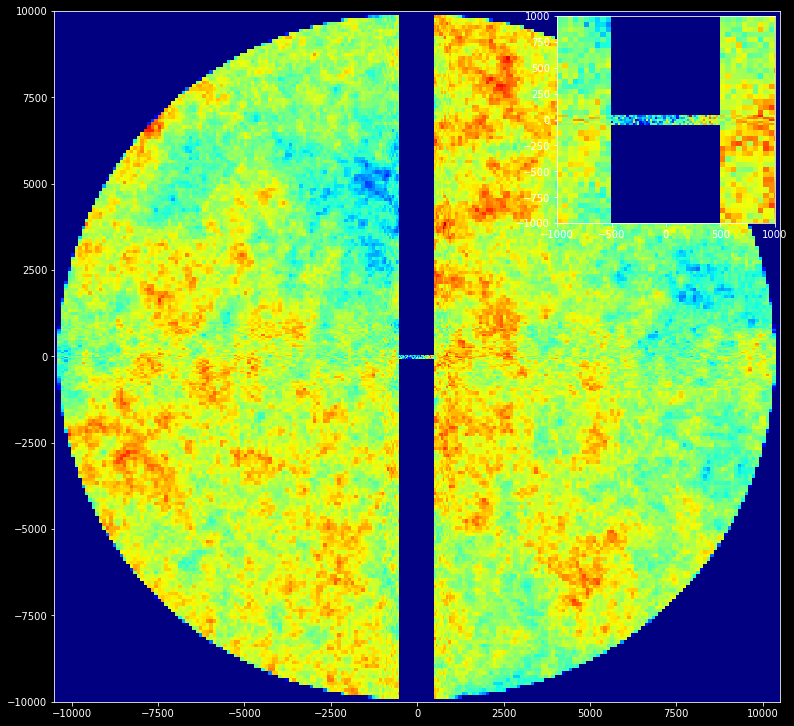

In [46]:
mean, std = np.mean(hist[hist>0]), np.std(hist[hist>0])
vmin, vmax = mean-1*std, mean+1*std
# https://matplotlib.org/stable/gallery/axes_grid1/inset_locator_demo.html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html
fig, ax = plt.subplots(figsize=(13,13))
X, Y = np.meshgrid(ex, ez)
ax.pcolormesh(X, Y, hist, cmap='jet', vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
axins = inset_axes(ax, width="30%", height="30%", loc=1)
axins.pcolormesh(X, Y, hist, cmap='jet', vmin=vmin, vmax=vmax)
axins.set_xlim(-1000,1000)
axins.set_ylim(-1000,1000)

AttributeError: 'NonUniformImage' object has no property 'vmin'

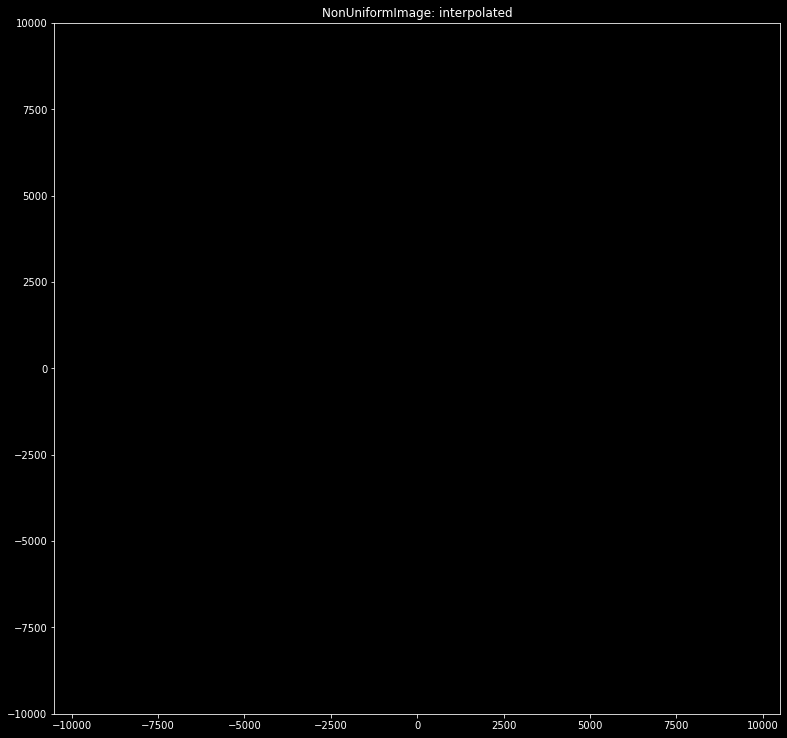

In [47]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, title='NonUniformImage: interpolated',
        aspect='equal', xlim=ex[[0, -1]], ylim=ez[[0, -1]])
im = NonUniformImage(ax, interpolation='bilinear', extent=[ex[0], ex[-1], ez[0], ez[-1]], cmap='jet')
xcenters = (ex[:-1] + ex[1:]) / 2
ycenters = (ez[:-1] + ez[1:]) / 2
im.set_data(xcenters, ycenters, hist)
ax.images.append(im)

ax.set_aspect('equal')
# ax.set_xlim(-2000,2000)
# ax.set_ylim(-2000,2000)

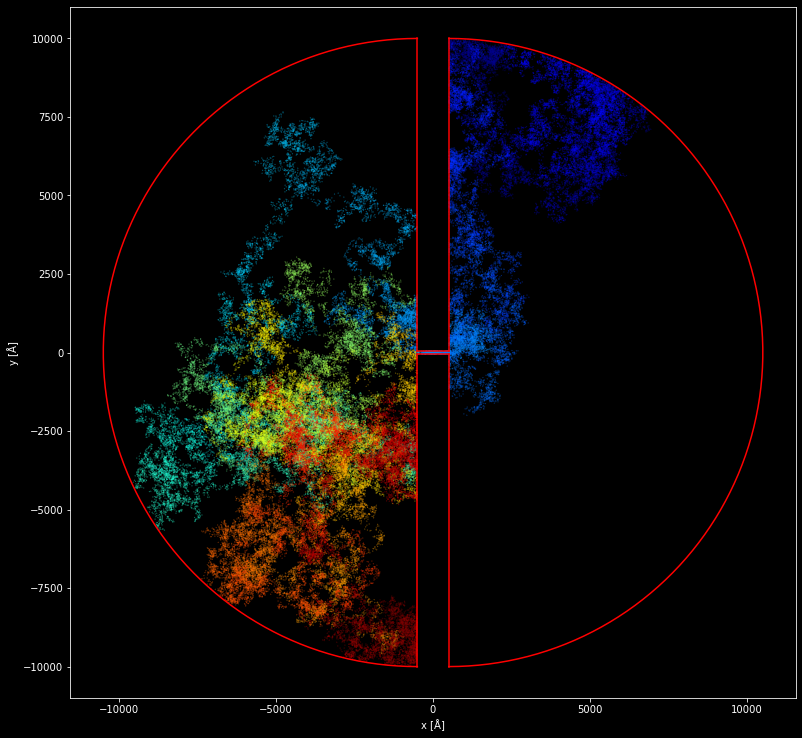

In [29]:
# Get particles that go inside the channel
# i_particle=1107
fig, ax = plt.subplots(figsize=(13,13))
# ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])
temp = np.argsort(np.sum(np.abs(trajectory[:,0,:-2])<L/2, axis=1))[::-1]
i_particle = temp[0]
ax.scatter(trajectory[i_particle,0,:], trajectory[i_particle,1,:], 
           c=np.arange(trajectory.shape[2]), marker='.', cmap='jet', s=0.1)
# for i_particle in temp[:1]:
#         ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])

# for i_particle in range(trajectory.shape[0]):
#         ax.plot(trajectory[i_particle,0,:2], trajectory[i_particle,1,:2])
ax.plot(R*np.cos(np.linspace(np.pi/2, 3*np.pi/2, 100))-L/2,
        R*np.sin(np.linspace(np.pi/2, 3*np.pi/2, 100)),c='r')
ax.plot(-R*np.cos(np.linspace(np.pi/2, 3*np.pi/2, 100))+L/2,
        R*np.sin(np.linspace(np.pi/2, 3*np.pi/2, 100)),c='r')
ax.plot([-L/2, -L/2], [R, h/2], c='r')
ax.plot([+L/2, +L/2], [R, h/2], c='r')
ax.plot([-L/2, +L/2], [h/2, h/2], c='r')
ax.plot([-L/2, +L/2], [-h/2, -h/2], c='r')
ax.plot([-L/2, -L/2], [-R, -h/2], c='r')
ax.plot([+L/2, +L/2], [-R, -h/2], c='r')
ax.set_xlabel('x [Å]')
ax.set_ylabel('y [Å]')
ax.set_aspect('equal')
# ax.set_xlim(-2000,2000)
# ax.set_ylim(-2000,2000)


In [13]:
u.run2(1_000_000);



With 8192 particles
GPU time per step:
cp.zeros: 0.004 us
cp.random.normal: 2.819 us
engine: 0.001 us
Total: 2.824 us
Need 2.82s to compute 1ms of simulation


In [5]:
import cupy as cp
def PSD_gpu(x, dt):
    x_gpu = cp.asarray(x)
    psd = (cp.abs(cp.fft.rfft(x_gpu))**2).get()
    freqs = (cp.fft.rfftfreq(x.size, dt)).get()
    del x_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd, freqs

def PSD_gpu_binned(x, dt, bins):
    x_gpu = cp.asarray(x)
    psd_gpu = cp.abs(cp.fft.rfft(x_gpu))**2
    freqs_gpu = cp.fft.rfftfreq(x.size, dt)

    psd_binned_gpu, freqs_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], 
                                        weights=cp.log(psd_gpu)[1:], bins=bins)
    N_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], bins=bins)[0]
    psd_averaged = (psd_binned_gpu/N_binned_gpu).get()
    freqs = ((freqs_binned_gpu[1:]+freqs_binned_gpu[:-1])/2.).get()
    
    del x_gpu, psd_gpu, freqs_gpu, psd_binned_gpu, freqs_binned_gpu, N_binned_gpu
    cp._default_memory_pool.free_all_blocks()
    return np.exp(psd_averaged), np.exp(freqs)

In [8]:
data = u[0]

Reading region_0 ...
... Done


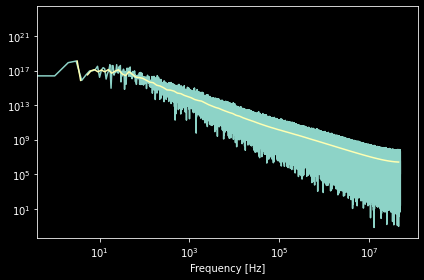

In [8]:
region_0 = data['region_0']
fig, ax = plt.subplots()
psd, freqs = PSD_gpu(region_0[::10], dt*10)
ax.loglog(freqs*1E15, psd)
psd_bin, freqs_bin = PSD_gpu_binned(region_0[::10], dt*10, bins=100)
ax.loglog(freqs_bin*1E15, psd_bin)
ax.set_xlabel('Frequency [Hz]')
fig.tight_layout()